## GlowByte Hackaton: Time Series Forecasting on Power Consumption

**Задача**
Разработка модели прогнозирования общего энергопотребления региона на сутки, в МВт*ч

**Цель**
Разработать надежную и точную модель прогнозирования объема энергопотребления на сутки для Калининградской области с использованием доступных исторических данных и соответствующих переменных.

**Описание задачи**
В данной задаче необходимо разработать предиктивную модель, которая позволит прогнозировать энергопотребление региона на основе имеющихся данных о потреблении электроэнергии в прошлом и соответствующих факторах, влияющих на потребление энергии. Модель должна быть способна учесть сезонные, временные и другие зависимости для более точного прогноза. Модель должна предсказывать общее потребление региона на 1 сутки.


## Libraries and data loading

c:\Users\sovie\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


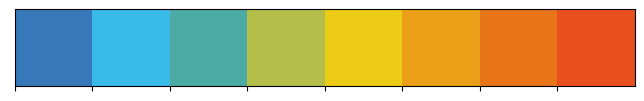

In [2]:
import pandas as pd
import numpy as np

from glowbyte_transformers import DatetimeTransformer, FillNATransformer, GeneralizeConditionTransformer, OneHotEncoderTransformer, ResampleDataTransformer, HolidaysTransformer, CovidTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_validate, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import VotingRegressor

#----------------------------
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

import optuna
import warnings

#Disable warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=Warning)

my_colors = ["#3778ba", "#37bae8", "#4caba4", "#b3bf49",
             "#edcc17", "#eb9f19", "#e9751a", "#e84f1c"]
sns.palplot(sns.color_palette(my_colors))


In [3]:
train_df = pd.read_csv('train_dataset.csv',  index_col='date', parse_dates=['date'])
test_df = pd.read_csv('test_dataset.csv',  index_col='date', parse_dates=['date'])

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37224 entries, 2019-01-01 to 2023-03-31
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          37224 non-null  int64  
 1   target        37224 non-null  float64
 2   temp          37224 non-null  float64
 3   temp_pred     37136 non-null  float64
 4   weather_pred  37136 non-null  object 
 5   weather_fact  37223 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 2.0+ MB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2928 entries, 2023-04-01 to 2023-07-31
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          2928 non-null   int64  
 1   target        2928 non-null   float64
 2   temp          2928 non-null   float64
 3   temp_pred     2904 non-null   float64
 4   weather_pred  2904 non-null   object 
 5   weather_fact  2928 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 160.1+ KB


## EDA

In [6]:
df = pd.concat([train_df, test_df], sort=False)

In [7]:
df.index.is_monotonic_increasing

True

<div style="padding:10px; color:white; font-size:120%; display:fill; background-color:#4caba4;">
    
+ Loaded train and test data, concated 2 dataframes
    
+ Missing values in columns `temp_pred ` and `weather_pred`
    
+ Data in the right order
</div>

In [8]:
df_new = df.groupby('date').agg(target=('target', 'sum'), min_temp=('temp_pred', 'min'), max_temp=('temp_pred', 'max'))

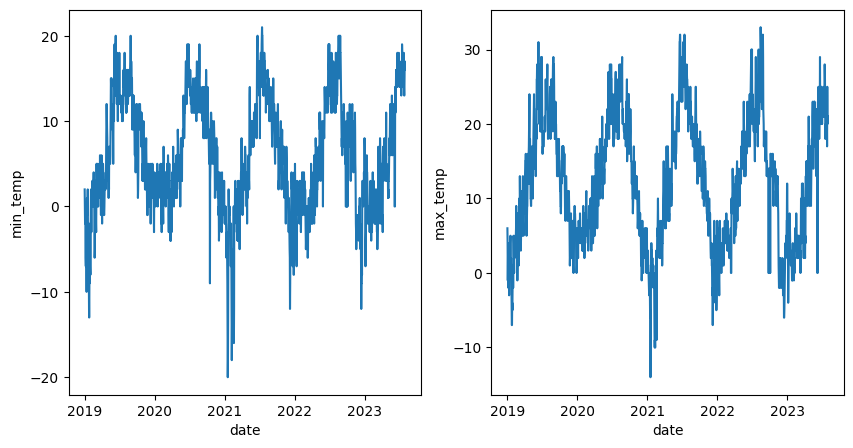

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

sns.lineplot(data=df_new, x='date', y='min_temp', ax=ax[0])
sns.lineplot(data=df_new, x='date', y='max_temp', ax=ax[1])
plt.show()

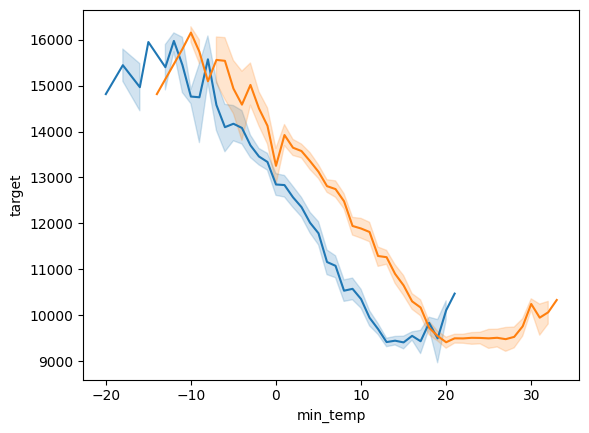

In [10]:
sns.lineplot(x='min_temp', y="target" ,data=df_new)
sns.lineplot(x='max_temp', y="target" ,data=df_new)
plt.show()

<div style="padding:10px; color:white; font-size:120%; display:fill; background-color:#4caba4;">
    
+ Temperatures have seasonality, as you would expect
+ The winter of 2021 was abnormally cold.
+ No temperature emissions were observed in summer
+ Energy consumption is higher during the cold season, then it decreases and slightly increases during the hottest time. Apparently, this is due to the use of air conditioners and fans

</div>

In [11]:
decomposition = seasonal_decompose(df_new[['target']])

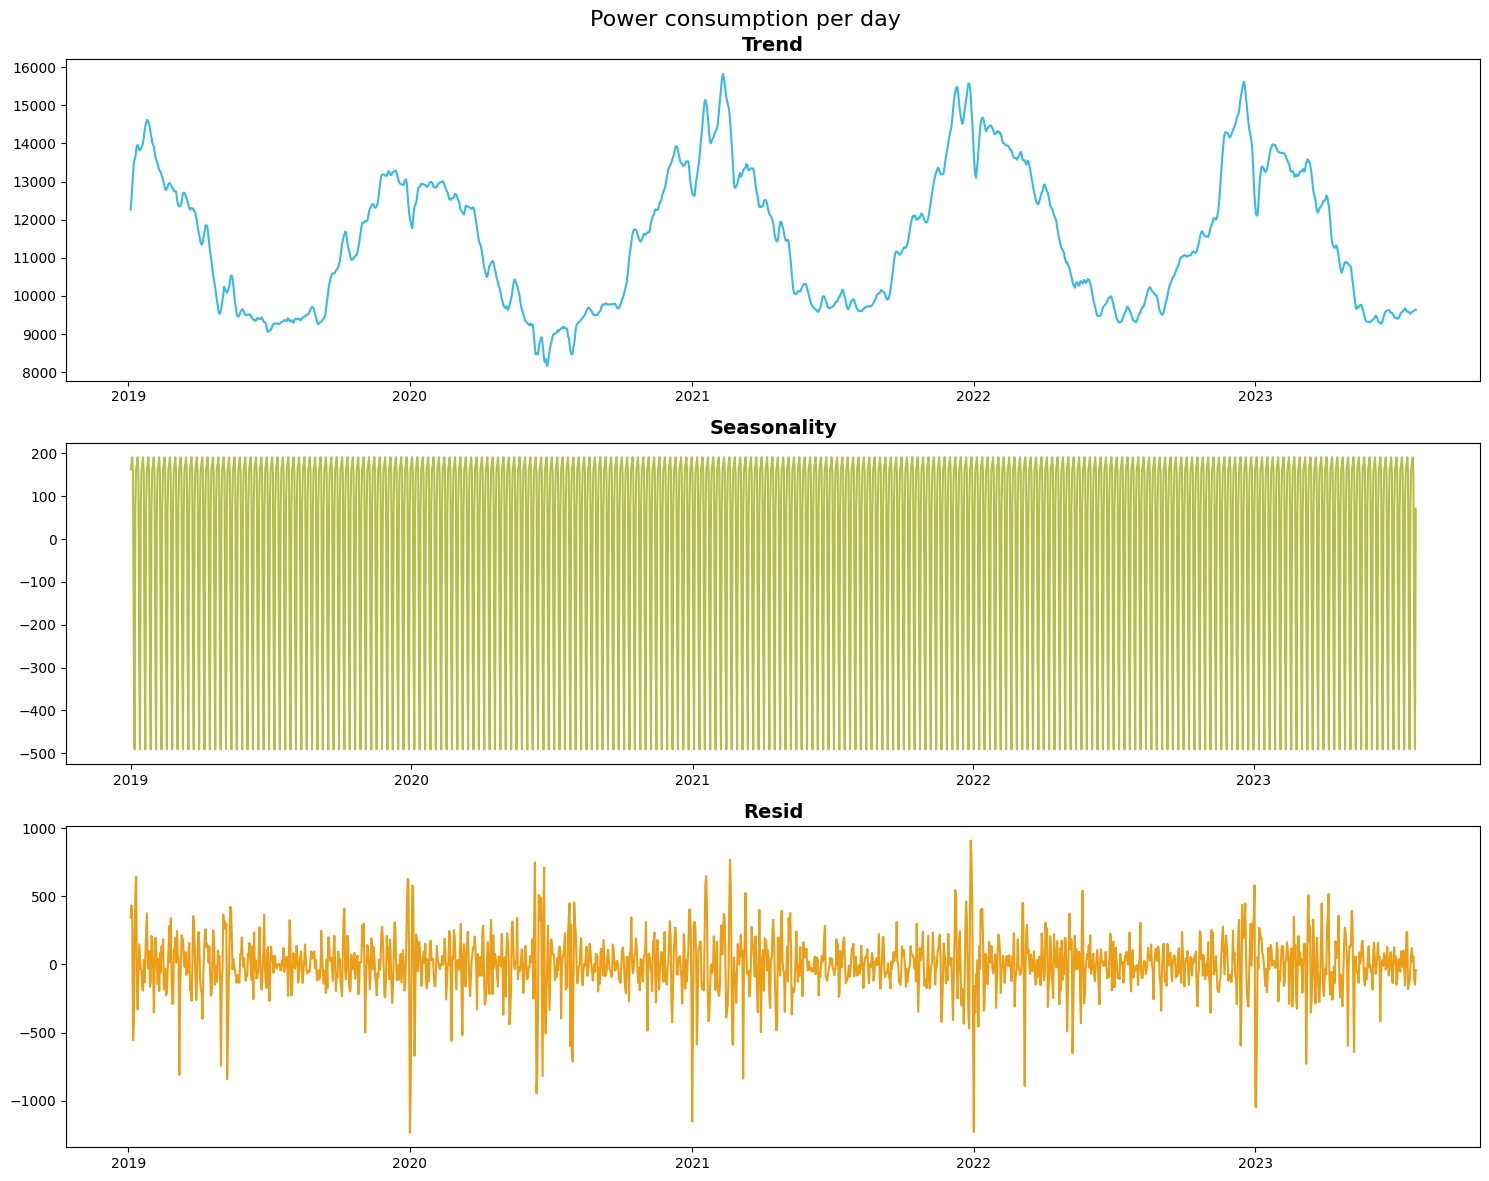

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
ax[0].plot(decomposition.trend, color=my_colors[1])
ax[0].set_title('Trend',size=14, weight='bold')
ax[1].plot(decomposition.seasonal, color=my_colors[3])
ax[1].set_title('Seasonality', size=14, weight='bold')
ax[2].plot(decomposition.resid, color=my_colors[5])
ax[2].set_title('Resid', size=14, weight='bold')
fig.suptitle('Power consumption per day', size=16)
fig.tight_layout()

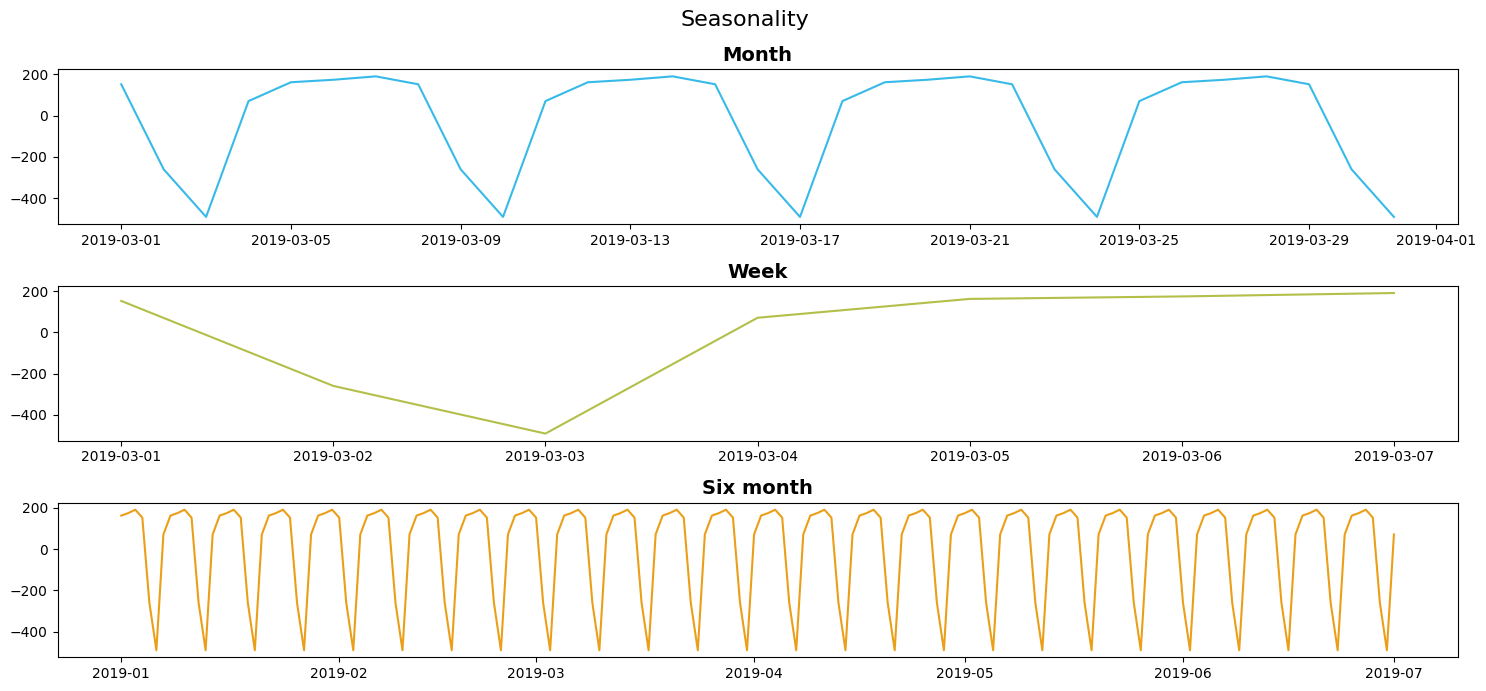

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(15, 7))
ax[0].plot(decomposition.seasonal['2019-03-01':'2019-03-31'], color=my_colors[1])
ax[0].set_title('Month', size=14, weight='bold')
ax[1].plot(decomposition.seasonal['2019-03-01':'2019-03-07'], color=my_colors[3])
ax[1].set_title('Week', size=14, weight='bold')
ax[2].plot(decomposition.seasonal['2019-01-01':'2019-07-01'], color=my_colors[5])
ax[2].set_title('Six month', size=14, weight='bold')
fig.suptitle('Seasonality', size=16)
fig.tight_layout()

<div style="padding:10px; color:white; font-size:120%; display:fill; background-color:#4caba4;">

    + There is a clear seasonality to energy consumption
    + 2022 there was a decrease in consumption
    + There is a decrease in energy consumption on Sundays
</div>

## Data Pre-processing

In [14]:
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

In [15]:
#Rename columns
column_mapping = {'weather_пасмурно': 'cloudy', 'weather_снег': 'snow',
                  'weather_ясно': 'clear',
                  'weather_дождь/ливень/гроза': 'rain', 'weather_туман': 'fog'}

In [16]:
#Pipeline steps
pipeline = Pipeline(steps=[
    ('datetime_transform', DatetimeTransformer()),
    ('fill_na', FillNATransformer()),
    ('generalize_condition', GeneralizeConditionTransformer()),
    ('one_hot_encode', OneHotEncoderTransformer(columns=['weather'], column_mapping=column_mapping)),
    ('resample_data', ResampleDataTransformer()),
    ('holidays', HolidaysTransformer()),
    ('covid', CovidTransformer()),
])

In [17]:
pipeline.fit(train_df)

Pipeline(steps=[('datetime_transform', DatetimeTransformer()),
                ('fill_na', FillNATransformer()),
                ('generalize_condition', GeneralizeConditionTransformer()),
                ('one_hot_encode',
                 OneHotEncoderTransformer(column_mapping={'weather_дождь/ливень/гроза': 'rain',
                                                          'weather_пасмурно': 'cloudy',
                                                          'weather_снег': 'snow',
                                                          'weather_туман': 'fog',
                                                          'weather_ясно': 'clear'},
                                          columns=['weather'])),
                ('resample_data', ResampleDataTransformer()),
                ('holidays', HolidaysTransformer()),
                ('covid', CovidTransformer())])

In [18]:
train_transformed = pipeline.transform(train_df)
test_transformed = pipeline.transform(test_df)

In [19]:
train_transformed.head()

,ds,target,temp_pred_mean,temp_pred_min,temp_pred_max,rain,cloudy,snow,clear,holiday,covid
0,2019-01-01,11126.866,4.375,2.0,6.0,1.0,1.0,0.0,0.0,1,0
1,2019-01-02,11547.210,1.500,0.0,4.0,1.0,1.0,1.0,0.0,1,0
2,2019-01-03,12235.564,-1.375,-2.0,-1.0,1.0,0.0,1.0,0.0,1,0
3,2019-01-04,12763.044,-0.125,-2.0,1.0,1.0,0.0,1.0,0.0,1,0
4,2019-01-05,12735.145,1.500,-2.0,4.0,1.0,0.0,0.0,1.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1546,2023-03-27,12513.596,1.250,-2.0,3.0,0.0,1.0,1.0,0.0,0,0
1547,2023-03-28,12988.331,-0.250,-2.0,2.0,0.0,1.0,1.0,1.0,0,0
1548,2023-03-29,12771.077,1.500,-2.0,5.0,1.0,1.0,0.0,1.0,0,0
1549,2023-03-30,12478.985,6.375,3.0,9.0,1.0,1.0,0.0,0.0,0,0


In [20]:
y_pred_previous_day = test_transformed['target'].shift(1)
y_pred_previous_day.iloc[0] = train_transformed['target'].iloc[-1]

In [21]:
def make_features(dataset, column_name, max_lag, rolling_mean_size):
    dataset = dataset.copy()
    dataset['year'] = dataset['ds'].dt.year
    dataset['month'] = dataset['ds'].dt.month
    dataset['day'] = dataset['ds'].dt.day
    dataset['dayofweek'] = dataset['ds'].dt.dayofweek
    dataset['dayofyear'] = dataset['ds'].dt.dayofyear

    for lag in range(1, max_lag + 1):
        dataset['lag_{}'.format(lag)] = dataset[column_name].shift(lag)

    dataset['rolling_mean'] = dataset[column_name].shift().rolling(rolling_mean_size).mean()
    return dataset

In [22]:
data = pd.concat([train_transformed, test_transformed], ignore_index=True)

In [23]:
data_f = make_features(data, 'target', 25, 25)

In [24]:
data_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1673 entries, 0 to 1672
Data columns (total 42 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ds              1673 non-null   datetime64[ns]
 1   target          1673 non-null   float64       
 2   temp_pred_mean  1673 non-null   float64       
 3   temp_pred_min   1673 non-null   float64       
 4   temp_pred_max   1673 non-null   float64       
 5   rain            1673 non-null   float64       
 6   cloudy          1673 non-null   float64       
 7   snow            1673 non-null   float64       
 8   clear           1673 non-null   float64       
 9   holiday         1673 non-null   int64         
 10  covid           1673 non-null   int64         
 11  year            1673 non-null   int32         
 12  month           1673 non-null   int32         
 13  day             1673 non-null   int32         
 14  dayofweek       1673 non-null   int32         
 15  dayo

In [25]:
# Определяем индекс, по которому разделить данные
split_index = len(train_transformed)

# Разделяем данные обратно на train_transformed и test_transformed
train_transformed_back = data_f.iloc[:split_index, :]
test_transformed_back = data_f.iloc[split_index:, :]

In [26]:
train_transformed_back.set_index('ds', inplace=True)
test_transformed_back.set_index('ds', inplace=True)

In [27]:
X_train = train_transformed_back.drop(['target'], axis=1)
y_train = train_transformed_back['target']
X_test = test_transformed_back.drop(['target'], axis=1)
y_test = test_transformed_back['target']

## Model training

In [28]:
tss = TimeSeriesSplit(n_splits=5)

In [29]:
model_metrics_dict = {
    'XGBRegressor+GridSearch': {},
    'XGBRegressor+OPTUNA': {},
    'LightGBMRegressor+GridSearch': {},
    'LightGBMRegressor+OPTUNA': {},
    'CatBoostRegressor+OPTUNA': {},
    'VotingRegressor':{}
}

In [30]:
def add_metrics_dict(predictions, dictionary):
    dictionary['MAE'] = mean_absolute_error(y_test, predictions)
    dictionary['MAPE'] = mean_absolute_percentage_error(y_test, predictions)
    dictionary['R2'] = r2_score(y_test, predictions)
    dictionary['RMSE'] = mean_squared_error(y_test, predictions, squared=False)


In [31]:
import pickle

def save_file(model, model_pkl_file):
    with open(model_pkl_file, 'wb') as file:  
        pickle.dump(model, file)

### XGBRegressor

Use GridSearchCV to tune hyperparameters

In [31]:
params = {'max_depth': [3, 6, 10],
          'learning_rate': [0.01, 0.1],
          'n_estimators': [100, 500, 700],
          'colsample_bytree': [0.3, 0.7], }

xgbr = xgb.XGBRegressor()
xgbr_gridcv = GridSearchCV(estimator=xgbr,
                   param_grid=params,
                   scoring='neg_mean_absolute_error',
                   cv=tss,
                   verbose=0,
                   n_jobs=-1)
xgbr_gridcv.fit(X_train, y_train)

print("Best parameters:", xgbr_gridcv.best_params_)
print("Lowest MAE: ", (-xgbr_gridcv.best_score_))

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
Lowest MAE:  238.42991285610464


In [32]:
xgbr_preds = xgbr_gridcv.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, xgbr_preds)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, xgbr_preds)}')
print(f'R2: {r2_score(y_test, xgbr_preds)}')

MAE: 139.0595406634221
MAPE: 0.01379849318882754
R2: 0.9661631439666025


In [33]:
add_metrics_dict(xgbr_preds, model_metrics_dict['XGBRegressor+GridSearch'])

Use Optuna to tune hyperparameters

In [34]:
# Objective for XGBRegressor/optuna study 
def objective(trial):

    param_grid = {
        'tweedie_variance_power': trial.suggest_discrete_uniform('tweedie_variance_power', 1.0, 2.0, 0.1),
        'max_depth': trial.suggest_int('max_depth', 6, 10), # Extremely prone to overfitting!
        'n_estimators': trial.suggest_int('n_estimators', 400, 4000, 400), # Extremely prone to overfitting!
        'eta': trial.suggest_float('eta', 0.007, 0.013), # Most important parameter.
        'subsample': trial.suggest_discrete_uniform('subsample', 0.2, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.2, 0.9, 0.1),
        'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.2, 0.9, 0.1),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-4, 1e4), # I've had trouble with LB score until tuning this.
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e4), # L2 regularization
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e4), # L1 regularization
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),
    } 
    
    model = xgb.XGBRegressor(
        **param_grid
    )

    scores = cross_validate(model, X_train, y_train, cv=tss, return_train_score=True,  scoring='neg_mean_absolute_error')

    return -scores['test_score'].mean()

In [35]:
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective, n_trials= 100, show_progress_bar = True)

[I 2023-10-23 16:06:25,274] A new study created in memory with name: no-name-c436193e-8124-43c3-b2f3-ddb1b917010d
Best trial: 0. Best value: 590.568:   1%|          | 1/100 [00:05<09:23,  5.69s/it]

[I 2023-10-23 16:06:30,965] Trial 0 finished with value: 590.5680253197676 and parameters: {'tweedie_variance_power': 2.0, 'max_depth': 6, 'n_estimators': 2800, 'eta': 0.01049244657755534, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'min_child_weight': 151.18778688193638, 'reg_lambda': 0.07018564211854218, 'reg_alpha': 413.5299045548647, 'gamma': 3.0565889178145946}. Best is trial 0 with value: 590.5680253197676.


Best trial: 1. Best value: 302.955:   2%|▏         | 2/100 [00:12<10:32,  6.45s/it]

[I 2023-10-23 16:06:37,936] Trial 1 finished with value: 302.9547884762597 and parameters: {'tweedie_variance_power': 2.0, 'max_depth': 10, 'n_estimators': 2000, 'eta': 0.011828821820154892, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.9, 'min_child_weight': 71.22292135924498, 'reg_lambda': 0.09459006442702876, 'reg_alpha': 0.006179474558706605, 'gamma': 0.00016772262007644172}. Best is trial 1 with value: 302.9547884762597.


Best trial: 1. Best value: 302.955:   3%|▎         | 3/100 [00:16<08:36,  5.33s/it]

[I 2023-10-23 16:06:41,943] Trial 2 finished with value: 1624.5047314631781 and parameters: {'tweedie_variance_power': 1.1, 'max_depth': 6, 'n_estimators': 3200, 'eta': 0.009881959903851122, 'subsample': 0.4, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'min_child_weight': 3426.089925582886, 'reg_lambda': 0.5486939246926661, 'reg_alpha': 0.000379880225867246, 'gamma': 14.584176595594553}. Best is trial 1 with value: 302.9547884762597.


Best trial: 1. Best value: 302.955:   4%|▍         | 4/100 [00:18<06:27,  4.04s/it]

[I 2023-10-23 16:06:44,009] Trial 3 finished with value: 1624.5047314631781 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 7, 'n_estimators': 1600, 'eta': 0.00925230254543897, 'subsample': 0.9, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.2, 'min_child_weight': 4212.058543656689, 'reg_lambda': 0.20738557634862417, 'reg_alpha': 0.41048422242758975, 'gamma': 0.9900302001450686}. Best is trial 1 with value: 302.9547884762597.


Best trial: 4. Best value: 281.632:   5%|▌         | 5/100 [00:26<08:34,  5.42s/it]

[I 2023-10-23 16:06:51,867] Trial 4 finished with value: 281.6324371293605 and parameters: {'tweedie_variance_power': 1.0, 'max_depth': 7, 'n_estimators': 2400, 'eta': 0.012729401513821195, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.05762523457374078, 'reg_lambda': 0.0014814638320418418, 'reg_alpha': 5.555715914099396, 'gamma': 8205.203487502218}. Best is trial 4 with value: 281.6324371293605.


Best trial: 4. Best value: 281.632:   6%|▌         | 6/100 [00:29<06:53,  4.40s/it]

[I 2023-10-23 16:06:54,300] Trial 5 finished with value: 1018.5931666860466 and parameters: {'tweedie_variance_power': 2.0, 'max_depth': 8, 'n_estimators': 1200, 'eta': 0.010234900855503421, 'subsample': 0.9, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.8, 'min_child_weight': 54.594178735454314, 'reg_lambda': 5382.883578954899, 'reg_alpha': 0.018880872945627833, 'gamma': 4333.013244126148}. Best is trial 4 with value: 281.6324371293605.


Best trial: 4. Best value: 281.632:   7%|▋         | 7/100 [00:47<13:51,  8.95s/it]

[I 2023-10-23 16:07:12,599] Trial 6 finished with value: 323.40645021681206 and parameters: {'tweedie_variance_power': 1.2, 'max_depth': 8, 'n_estimators': 2400, 'eta': 0.0117665082473053, 'subsample': 0.5, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.4, 'min_child_weight': 0.0015952985142290205, 'reg_lambda': 176.51520351416627, 'reg_alpha': 123.22927442266787, 'gamma': 0.002278181436267922}. Best is trial 4 with value: 281.6324371293605.


Best trial: 4. Best value: 281.632:   8%|▊         | 8/100 [01:13<22:18, 14.55s/it]

[I 2023-10-23 16:07:39,148] Trial 7 finished with value: 326.4088169622093 and parameters: {'tweedie_variance_power': 1.8, 'max_depth': 9, 'n_estimators': 3200, 'eta': 0.011763323167686093, 'subsample': 0.7, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.2, 'min_child_weight': 0.022462700329564815, 'reg_lambda': 0.008002354671950134, 'reg_alpha': 0.0003392811569968693, 'gamma': 17.64904581412372}. Best is trial 4 with value: 281.6324371293605.


Best trial: 4. Best value: 281.632:   9%|▉         | 9/100 [01:14<15:26, 10.18s/it]

[I 2023-10-23 16:07:39,734] Trial 8 finished with value: 1624.5047314631781 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 7, 'n_estimators': 400, 'eta': 0.012190940732746782, 'subsample': 0.7, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.8, 'min_child_weight': 9729.031494548419, 'reg_lambda': 1303.0901179646187, 'reg_alpha': 0.0008571526495129376, 'gamma': 0.11648907329212069}. Best is trial 4 with value: 281.6324371293605.


Best trial: 4. Best value: 281.632:  10%|█         | 10/100 [01:16<11:43,  7.82s/it]

[I 2023-10-23 16:07:42,249] Trial 9 finished with value: 1021.3478433212209 and parameters: {'tweedie_variance_power': 1.3, 'max_depth': 10, 'n_estimators': 800, 'eta': 0.012179645459491309, 'subsample': 0.2, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.4, 'min_child_weight': 0.000963289710630815, 'reg_lambda': 938.3849410827183, 'reg_alpha': 196.47215223890447, 'gamma': 0.00010939568713977866}. Best is trial 4 with value: 281.6324371293605.


Best trial: 4. Best value: 281.632:  11%|█         | 11/100 [01:27<12:49,  8.65s/it]

[I 2023-10-23 16:07:52,767] Trial 10 finished with value: 351.40377414486437 and parameters: {'tweedie_variance_power': 1.0, 'max_depth': 7, 'n_estimators': 4000, 'eta': 0.007340647977932381, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.18689838486856902, 'reg_lambda': 0.00015456457075331063, 'reg_alpha': 8489.401521035068, 'gamma': 4131.79815611225}. Best is trial 4 with value: 281.6324371293605.


Best trial: 11. Best value: 262.574:  12%|█▏        | 12/100 [02:10<28:09, 19.19s/it]

[I 2023-10-23 16:08:36,087] Trial 11 finished with value: 262.57368609375 and parameters: {'tweedie_variance_power': 1.4, 'max_depth': 10, 'n_estimators': 2000, 'eta': 0.012958545063868688, 'subsample': 0.7, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'min_child_weight': 1.0408632540246034, 'reg_lambda': 0.002734648153038021, 'reg_alpha': 0.7214981772262441, 'gamma': 0.009771011125484215}. Best is trial 11 with value: 262.57368609375.


Best trial: 12. Best value: 261.357:  13%|█▎        | 13/100 [02:27<26:47, 18.48s/it]

[I 2023-10-23 16:08:52,933] Trial 12 finished with value: 261.35674040576555 and parameters: {'tweedie_variance_power': 1.4, 'max_depth': 9, 'n_estimators': 2000, 'eta': 0.012972785301203374, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'min_child_weight': 1.0750593557462638, 'reg_lambda': 0.00041385055786478036, 'reg_alpha': 1.0936055685408532, 'gamma': 378.53089390271833}. Best is trial 12 with value: 261.35674040576555.


Best trial: 13. Best value: 235.297:  14%|█▍        | 14/100 [02:48<27:33, 19.23s/it]

[I 2023-10-23 16:09:13,886] Trial 13 finished with value: 235.29746271681202 and parameters: {'tweedie_variance_power': 1.4, 'max_depth': 9, 'n_estimators': 1600, 'eta': 0.012979415038466691, 'subsample': 0.5, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'min_child_weight': 2.064634612932266, 'reg_lambda': 0.00011747801365863615, 'reg_alpha': 0.3501677795267958, 'gamma': 0.017677829230313073}. Best is trial 13 with value: 235.29746271681202.


Best trial: 13. Best value: 235.297:  15%|█▌        | 15/100 [03:02<25:08, 17.74s/it]

[I 2023-10-23 16:09:28,195] Trial 14 finished with value: 239.8798902301357 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 9, 'n_estimators': 1200, 'eta': 0.012888222847799533, 'subsample': 0.5, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'min_child_weight': 3.5587596968540245, 'reg_lambda': 0.00010691862916474062, 'reg_alpha': 0.1967290535832629, 'gamma': 101.22773770467961}. Best is trial 13 with value: 235.29746271681202.


Best trial: 15. Best value: 233.167:  16%|█▌        | 16/100 [03:14<22:09, 15.83s/it]

[I 2023-10-23 16:09:39,557] Trial 15 finished with value: 233.16661583575583 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 9, 'n_estimators': 1200, 'eta': 0.01104052295190359, 'subsample': 0.4, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'min_child_weight': 5.1158490962919885, 'reg_lambda': 0.0002613295961472248, 'reg_alpha': 0.026308542604296832, 'gamma': 0.08412400614511184}. Best is trial 15 with value: 233.16661583575583.


Best trial: 15. Best value: 233.167:  17%|█▋        | 17/100 [03:17<16:47, 12.14s/it]

[I 2023-10-23 16:09:43,128] Trial 16 finished with value: 254.29269434835274 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 9, 'n_estimators': 400, 'eta': 0.011263573043252761, 'subsample': 0.4, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 7.120093493470649, 'reg_lambda': 0.00998611391404296, 'reg_alpha': 0.03011929673926595, 'gamma': 0.08079784482627564}. Best is trial 15 with value: 233.16661583575583.


Best trial: 15. Best value: 233.167:  18%|█▊        | 18/100 [03:37<19:35, 14.34s/it]

[I 2023-10-23 16:10:02,586] Trial 17 finished with value: 246.9875549890988 and parameters: {'tweedie_variance_power': 1.3, 'max_depth': 8, 'n_estimators': 1200, 'eta': 0.011049197589359194, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'min_child_weight': 0.205542145873924, 'reg_lambda': 0.0007870255153795275, 'reg_alpha': 0.006778402681916249, 'gamma': 0.13243390665331903}. Best is trial 15 with value: 233.16661583575583.


Best trial: 15. Best value: 233.167:  19%|█▉        | 19/100 [03:48<18:01, 13.36s/it]

[I 2023-10-23 16:10:13,659] Trial 18 finished with value: 240.0940287475775 and parameters: {'tweedie_variance_power': 1.8, 'max_depth': 9, 'n_estimators': 1600, 'eta': 0.010994423852108902, 'subsample': 0.4, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 9.449430669784368, 'reg_lambda': 14.26866666521708, 'reg_alpha': 0.09994845791838007, 'gamma': 0.0042443079108179784}. Best is trial 15 with value: 233.16661583575583.


Best trial: 15. Best value: 233.167:  20%|██        | 20/100 [04:03<18:32, 13.90s/it]

[I 2023-10-23 16:10:28,824] Trial 19 finished with value: 236.8220099249031 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 10, 'n_estimators': 800, 'eta': 0.009372750781286198, 'subsample': 0.2, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.8, 'min_child_weight': 0.006839250397985873, 'reg_lambda': 0.0001120765410906128, 'reg_alpha': 3.507679173768602, 'gamma': 0.026787925741112828}. Best is trial 15 with value: 233.16661583575583.


Best trial: 15. Best value: 233.167:  21%|██        | 21/100 [04:28<22:48, 17.33s/it]

[I 2023-10-23 16:10:54,140] Trial 20 finished with value: 248.74142642199612 and parameters: {'tweedie_variance_power': 1.2, 'max_depth': 8, 'n_estimators': 1600, 'eta': 0.012440096931544905, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.3231564642135266, 'reg_lambda': 0.015917225897617928, 'reg_alpha': 0.0019123860202777444, 'gamma': 0.9207110502452287}. Best is trial 15 with value: 233.16661583575583.


Best trial: 15. Best value: 233.167:  22%|██▏       | 22/100 [04:43<21:21, 16.42s/it]

[I 2023-10-23 16:11:08,463] Trial 21 finished with value: 235.4322969464632 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 10, 'n_estimators': 800, 'eta': 0.009423684188703907, 'subsample': 0.2, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.8, 'min_child_weight': 0.00011399529354186633, 'reg_lambda': 0.00011065740485304885, 'reg_alpha': 5.902222021480954, 'gamma': 0.02433864137657925}. Best is trial 15 with value: 233.16661583575583.


Best trial: 15. Best value: 233.167:  23%|██▎       | 23/100 [05:01<21:45, 16.95s/it]

[I 2023-10-23 16:11:26,639] Trial 22 finished with value: 234.83382851744187 and parameters: {'tweedie_variance_power': 1.4, 'max_depth': 10, 'n_estimators': 800, 'eta': 0.008887161992568497, 'subsample': 0.2, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'min_child_weight': 0.0006633319993694671, 'reg_lambda': 0.0007020717680715397, 'reg_alpha': 0.05174779759911647, 'gamma': 0.0018620276898127504}. Best is trial 15 with value: 233.16661583575583.


Best trial: 15. Best value: 233.167:  24%|██▍       | 24/100 [05:35<28:05, 22.18s/it]

[I 2023-10-23 16:12:01,029] Trial 23 finished with value: 245.1896036870155 and parameters: {'tweedie_variance_power': 1.4, 'max_depth': 9, 'n_estimators': 1200, 'eta': 0.008423619150164516, 'subsample': 0.5, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'min_child_weight': 0.05432519979210062, 'reg_lambda': 0.000978144957830132, 'reg_alpha': 0.06237406875223825, 'gamma': 0.0031005970687541014}. Best is trial 15 with value: 233.16661583575583.


Best trial: 15. Best value: 233.167:  25%|██▌       | 25/100 [05:42<22:02, 17.63s/it]

[I 2023-10-23 16:12:08,049] Trial 24 finished with value: 275.5006854275678 and parameters: {'tweedie_variance_power': 1.3, 'max_depth': 10, 'n_estimators': 400, 'eta': 0.01068254681634087, 'subsample': 0.4, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.7, 'min_child_weight': 2.034714092466321, 'reg_lambda': 0.0039636120760325865, 'reg_alpha': 0.01142706037398484, 'gamma': 0.0004288947678617534}. Best is trial 15 with value: 233.16661583575583.


Best trial: 15. Best value: 233.167:  26%|██▌       | 26/100 [05:47<16:51, 13.67s/it]

[I 2023-10-23 16:12:12,451] Trial 25 finished with value: 242.9949695482074 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 9, 'n_estimators': 800, 'eta': 0.011373911201982187, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 14.823835702225209, 'reg_lambda': 0.000495899934931862, 'reg_alpha': 0.09305161486646506, 'gamma': 0.000934410707773027}. Best is trial 15 with value: 233.16661583575583.


Best trial: 15. Best value: 233.167:  27%|██▋       | 27/100 [06:41<31:25, 25.83s/it]

[I 2023-10-23 16:13:06,683] Trial 26 finished with value: 245.752904722626 and parameters: {'tweedie_variance_power': 1.2, 'max_depth': 10, 'n_estimators': 1600, 'eta': 0.01005001668680776, 'subsample': 0.5, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'min_child_weight': 0.44577065694843554, 'reg_lambda': 0.0026101260809773476, 'reg_alpha': 0.0038080064052112787, 'gamma': 0.0009045632861222543}. Best is trial 15 with value: 233.16661583575583.


Best trial: 15. Best value: 233.167:  28%|██▊       | 28/100 [06:54<26:27, 22.05s/it]

[I 2023-10-23 16:13:19,909] Trial 27 finished with value: 257.15206917877913 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 9, 'n_estimators': 1200, 'eta': 0.010686102031350706, 'subsample': 0.4, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.5, 'min_child_weight': 2.1469309573593423, 'reg_lambda': 0.02603364141344633, 'reg_alpha': 0.06612003437680346, 'gamma': 0.018463572120699046}. Best is trial 15 with value: 233.16661583575583.


Best trial: 28. Best value: 223.783:  29%|██▉       | 29/100 [07:23<28:24, 24.00s/it]

[I 2023-10-23 16:13:48,457] Trial 28 finished with value: 223.7825791896802 and parameters: {'tweedie_variance_power': 1.4, 'max_depth': 8, 'n_estimators': 1600, 'eta': 0.011450513730912625, 'subsample': 0.2, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.8, 'min_child_weight': 0.010638917182225174, 'reg_lambda': 0.0005180412706893384, 'reg_alpha': 0.001755698633278267, 'gamma': 0.19621735573868423}. Best is trial 28 with value: 223.7825791896802.


Best trial: 28. Best value: 223.783:  30%|███       | 30/100 [07:34<23:41, 20.31s/it]

[I 2023-10-23 16:14:00,133] Trial 29 finished with value: 230.6149670954457 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 8, 'n_estimators': 800, 'eta': 0.010540260312953277, 'subsample': 0.2, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.8, 'min_child_weight': 0.00011417361581700761, 'reg_lambda': 0.056078033228359636, 'reg_alpha': 0.001972648743402256, 'gamma': 0.3666775739914464}. Best is trial 28 with value: 223.7825791896802.


Best trial: 28. Best value: 223.783:  31%|███       | 31/100 [08:22<32:52, 28.58s/it]

[I 2023-10-23 16:14:48,034] Trial 30 finished with value: 238.25600772044572 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 8, 'n_estimators': 2800, 'eta': 0.010478986809806065, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.8, 'min_child_weight': 0.00012920444266315679, 'reg_lambda': 0.033229091463425654, 'reg_alpha': 0.0014056228662041625, 'gamma': 0.8710571810042288}. Best is trial 28 with value: 223.7825791896802.


Best trial: 28. Best value: 223.783:  32%|███▏      | 32/100 [08:35<27:02, 23.87s/it]

[I 2023-10-23 16:15:00,902] Trial 31 finished with value: 227.89628024951548 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 8, 'n_estimators': 800, 'eta': 0.01147555638450469, 'subsample': 0.2, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.8, 'min_child_weight': 0.0003530694439615307, 'reg_lambda': 0.004652585170190695, 'reg_alpha': 0.00023542488663777833, 'gamma': 0.34918399709306747}. Best is trial 28 with value: 223.7825791896802.


Best trial: 28. Best value: 223.783:  33%|███▎      | 33/100 [08:42<20:54, 18.72s/it]

[I 2023-10-23 16:15:07,619] Trial 32 finished with value: 248.62901124515506 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 8, 'n_estimators': 400, 'eta': 0.011247679824021252, 'subsample': 0.2, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'min_child_weight': 0.0003408439534453354, 'reg_lambda': 0.06464604839230348, 'reg_alpha': 0.00024367594819013058, 'gamma': 0.2580687672761453}. Best is trial 28 with value: 223.7825791896802.


Best trial: 28. Best value: 223.783:  34%|███▍      | 34/100 [09:01<20:54, 19.00s/it]

[I 2023-10-23 16:15:27,267] Trial 33 finished with value: 226.4695336773256 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 8, 'n_estimators': 1200, 'eta': 0.010856717558640564, 'subsample': 0.2, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.8, 'min_child_weight': 0.001901956626593242, 'reg_lambda': 0.005698160826109971, 'reg_alpha': 0.00014971116984603493, 'gamma': 2.8716281576692864}. Best is trial 28 with value: 223.7825791896802.


Best trial: 28. Best value: 223.783:  35%|███▌      | 35/100 [09:28<22:59, 21.22s/it]

[I 2023-10-23 16:15:53,668] Trial 34 finished with value: 254.88855481952524 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 8, 'n_estimators': 2000, 'eta': 0.011591121339820577, 'subsample': 0.2, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.9, 'min_child_weight': 0.003420071941790307, 'reg_lambda': 0.1303148450088097, 'reg_alpha': 0.0001211422449746055, 'gamma': 3.5771506382807257}. Best is trial 28 with value: 223.7825791896802.


Best trial: 28. Best value: 223.783:  36%|███▌      | 36/100 [09:39<19:24, 18.19s/it]

[I 2023-10-23 16:16:04,799] Trial 35 finished with value: 239.07930762960268 and parameters: {'tweedie_variance_power': 1.3, 'max_depth': 7, 'n_estimators': 800, 'eta': 0.011584038401744073, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8, 'min_child_weight': 0.00030748025884696356, 'reg_lambda': 0.0055129167981088165, 'reg_alpha': 0.00011219547669229082, 'gamma': 0.44188341671142845}. Best is trial 28 with value: 223.7825791896802.


Best trial: 28. Best value: 223.783:  37%|███▋      | 37/100 [09:55<18:22, 17.50s/it]

[I 2023-10-23 16:16:20,684] Trial 36 finished with value: 223.97911703488376 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 6, 'n_estimators': 1600, 'eta': 0.010320399054512758, 'subsample': 0.2, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'min_child_weight': 0.003703133584100791, 'reg_lambda': 0.03859795579671327, 'reg_alpha': 0.0006395206154806534, 'gamma': 2.7985032724844046}. Best is trial 28 with value: 223.7825791896802.


Best trial: 28. Best value: 223.783:  38%|███▊      | 38/100 [10:22<20:57, 20.28s/it]

[I 2023-10-23 16:16:47,436] Trial 37 finished with value: 231.7823834895833 and parameters: {'tweedie_variance_power': 1.8, 'max_depth': 6, 'n_estimators': 2400, 'eta': 0.012005582799712235, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'min_child_weight': 0.006786818228426602, 'reg_lambda': 0.4438815059652585, 'reg_alpha': 0.0005385902141022965, 'gamma': 2.178145337178189}. Best is trial 28 with value: 223.7825791896802.


Best trial: 28. Best value: 223.783:  39%|███▉      | 39/100 [10:36<18:51, 18.55s/it]

[I 2023-10-23 16:17:01,951] Trial 38 finished with value: 242.90650069525196 and parameters: {'tweedie_variance_power': 1.9, 'max_depth': 6, 'n_estimators': 1600, 'eta': 0.010015036805502229, 'subsample': 0.2, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.9, 'min_child_weight': 0.00284303062695397, 'reg_lambda': 0.0017856356037167257, 'reg_alpha': 0.0005745803221820044, 'gamma': 3.9745033114963033}. Best is trial 28 with value: 223.7825791896802.


Best trial: 28. Best value: 223.783:  40%|████      | 40/100 [10:54<18:19, 18.32s/it]

[I 2023-10-23 16:17:19,723] Trial 39 finished with value: 284.5903371959787 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 6, 'n_estimators': 2000, 'eta': 0.011867578130227457, 'subsample': 0.8, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.8, 'min_child_weight': 0.01374203747976134, 'reg_lambda': 0.012454062619911081, 'reg_alpha': 0.00022510305362843762, 'gamma': 10.223439723684374}. Best is trial 28 with value: 223.7825791896802.


Best trial: 28. Best value: 223.783:  41%|████      | 41/100 [11:23<21:05, 21.44s/it]

[I 2023-10-23 16:17:48,455] Trial 40 finished with value: 225.06224192587212 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 7, 'n_estimators': 2400, 'eta': 0.010303035797013015, 'subsample': 0.2, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'min_child_weight': 0.002552344010381908, 'reg_lambda': 0.21817231006569732, 'reg_alpha': 0.0035762148417509835, 'gamma': 1.3851051889061998}. Best is trial 28 with value: 223.7825791896802.


Best trial: 28. Best value: 223.783:  42%|████▏     | 42/100 [11:59<24:55, 25.79s/it]

[I 2023-10-23 16:18:24,400] Trial 41 finished with value: 226.97117209181206 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 7, 'n_estimators': 2800, 'eta': 0.010249261203941462, 'subsample': 0.2, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'min_child_weight': 0.0014267165327010432, 'reg_lambda': 0.2081929108640656, 'reg_alpha': 0.0034015336607762185, 'gamma': 2.7464229678439778}. Best is trial 28 with value: 223.7825791896802.


Best trial: 28. Best value: 223.783:  42%|████▏     | 42/100 [12:11<16:50, 17.43s/it]


[W 2023-10-23 16:18:37,139] Trial 42 failed with parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 7, 'n_estimators': 2800, 'eta': 0.010274440738766058, 'subsample': 0.2, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'min_child_weight': 0.0015855119596979374, 'reg_lambda': 0.25898836626229343, 'reg_alpha': 0.0038127969591344015, 'gamma': 1.3524390349818698} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\sovie\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\sovie\AppData\Local\Temp\ipykernel_5644\1220825831.py", line 22, in objective
    scores = cross_validate(model, X_train, y_train, cv=tss, return_train_score=True,  scoring='neg_mean_absolute_error')
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [ ]:
print('Number of finished trials:', len(study_xgb.trials))
print('Best trial:', study_xgb.best_trial.params)
print('Best MAE:', study_xgb.best_value)

Number of finished trials: 100
Best trial: {'tweedie_variance_power': 1.9, 'max_depth': 8, 'n_estimators': 2000, 'eta': 0.008517954469063895, 'subsample': 0.2, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'min_child_weight': 1.084780881880628, 'reg_lambda': 0.0013361984930914735, 'reg_alpha': 0.8904523999825706, 'gamma': 105.20924811184948}
Best MAE: 219.3130397093023


In [ ]:
params = study_xgb.best_params
xgb_model = xgb.XGBRegressor(**params).fit(X_train, y_train)


In [ ]:
xgb_preds = xgb_model.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, xgb_preds)}')
print(f'RMSE: {mean_squared_error(y_test, xgb_preds, squared=False)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, xgb_preds)}')
print(f'R2: {r2_score(y_test, xgb_preds)}')
add_metrics_dict(xgb_preds, model_metrics_dict['XGBRegressor+OPTUNA'])

MAE: 120.2145308017418
RMSE: 154.10046898396465
MAPE: 0.011956078914933882
R2: 0.9733782359376602


In [ ]:
save_file(xgb_model, 'xgb_model.pkl')

### LightGBMRegressor
Use GridSearchCV to tune hyperparameters

In [ ]:
params = {'num_leaves': [10, 20, 40], 
          'num_iterations': [200, 1000, 1500],
          'max_depth': [5, 10, 20],
          'learning_rate':[0.01, 0.1], 
          'bagging_fraction':[0.5, 0.8]}
lgbr = lgb.LGBMRegressor(verbose=-1)
lgbr_gridcv = GridSearchCV(estimator=lgbr,
                   param_grid=params,
                   scoring='neg_mean_absolute_error',
                   n_jobs=-1,
                   cv=tss)
lgbr_gridcv.fit(X_train, y_train)

print("Best parameters:", lgbr_gridcv.best_params_)
print("Lowest MAE: ", -lgbr_gridcv.best_score_)

/Users/user/PycharmProjects/hakaton/venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/user/PycharmProjects/hakaton/venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/user/PycharmProjects/hakaton/venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/user/PycharmProjects/hakaton/venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argumen

Best parameters: {'bagging_fraction': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'num_iterations': 200, 'num_leaves': 10}
Lowest MAE:  233.250423000843


In [ ]:
lgbr_preds = lgbr_gridcv.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, lgbr_preds)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, lgbr_preds)}')
print(f'R2: {r2_score(y_test, lgbr_preds)}')
add_metrics_dict(lgbr_preds, model_metrics_dict['LightGBMRegressor+GridSearch'])

MAE: 142.36172262310782
MAPE: 0.01426117032509967
R2: 0.9626317782465958


Use Optuna to tune hyperparameters

In [ ]:
# Objective for LGBMRegressor/optuna study 
def objective(trial):
    params = {
        "objective": "regression",
        "metric": "mae",
        "n_estimators": 1000,
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "max_depth": trial.suggest_categorical("max_depth", [5, 10,20]),
        "verbose": -1
    }

    model = lgb.LGBMRegressor(**params)
    
    scores = cross_validate(model, X_train, y_train, cv=tss, return_train_score=True,  scoring='neg_mean_absolute_error')

    return - scores['test_score'].mean()

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2023-10-23 13:18:21,981] A new study created in memory with name: no-name-40f8c575-642a-44dc-9fcd-f825fdc8a839
[I 2023-10-23 13:18:35,154] Trial 0 finished with value: 261.60356099929356 and parameters: {'learning_rate': 0.023597050338021786, 'num_leaves': 599, 'subsample': 0.8574335091325629, 'colsample_bytree': 0.41903336433637267, 'min_data_in_leaf': 24, 'max_depth': 10}. Best is trial 0 with value: 261.60356099929356.
[I 2023-10-23 13:18:39,047] Trial 1 finished with value: 344.97188078307255 and parameters: {'learning_rate': 0.004008150911606723, 'num_leaves': 349, 'subsample': 0.6683720188370418, 'colsample_bytree': 0.562416516430434, 'min_data_in_leaf': 80, 'max_depth': 5}. Best is trial 0 with value: 261.60356099929356.
[I 2023-10-23 13:18:41,373] Trial 2 finished with value: 575.6617543889639 and parameters: {'learning_rate': 0.01090162890050038, 'num_leaves': 169, 'subsample': 0.23926672931100168, 'colsample_bytree': 0.257038379780703, 'min_data_in_leaf': 58, 'max_depth': 

In [ ]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best MAE:', study.best_value)

Number of finished trials: 100
Best trial: {'learning_rate': 0.011717420607105651, 'num_leaves': 8, 'subsample': 0.24838731622393367, 'colsample_bytree': 0.8804259878560188, 'min_data_in_leaf': 1, 'max_depth': 20}
Best MAE: 218.72012011486814


In [ ]:
params = study.best_params
lgbm_model = lgb.LGBMRegressor(**params).fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7271
[LightGBM] [Info] Number of data points in the train set: 1551, number of used features: 40
[LightGBM] [Info] Start training from score 11609.554594


In [ ]:
lgbm_preds = lgbm_model.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, lgbm_preds)}')
print(f'RMSE: {mean_squared_error(y_test, lgbm_preds, squared=False)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, lgbm_preds)}')
print(f'R2: {r2_score(y_test, lgbm_preds)}')
add_metrics_dict(lgbm_preds, model_metrics_dict['LightGBMRegressor+OPTUNA'])

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
MAE: 551.6568893605364
RMSE: 609.7136054314813
MAPE: 0.05682710641251931
R2: 0.5832451317867854


In [ ]:
save_file(lgbm_model, 'lgbm_model.pkl')

### CatboostRegressor

In [ ]:
# Objective for CatBoostRegressor/optuna study 
def objective(trial):
    params = {
        "iterations": trial.suggest_int('iterations', 100, 300),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }
    
    model = CatBoostRegressor(**params, silent=True)
    scores = cross_validate(model, X_train, y_train, cv=tss, return_train_score=True, scoring='neg_mean_absolute_error')

    return -scores['test_score'].mean()

In [ ]:
study_cb = optuna.create_study(direction="minimize")
# Run optimization process
study_cb.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2023-10-23 14:22:00,692] A new study created in memory with name: no-name-fd5acaac-b96b-4cdc-99d6-648e8ebf87bf


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-10-23 14:22:01,235] Trial 0 finished with value: 354.08583712496477 and parameters: {'iterations': 100, 'learning_rate': 0.3141944956090615, 'depth': 5, 'subsample': 0.10068169300171384, 'colsample_bylevel': 0.5179425411324527, 'min_data_in_leaf': 71}. Best is trial 0 with value: 354.08583712496477.
[I 2023-10-23 14:22:01,780] Trial 1 finished with value: 336.2267284469366 and parameters: {'iterations': 220, 'learning_rate': 0.4340642562480133, 'depth': 4, 'subsample': 0.596736658627204, 'colsample_bylevel': 0.6351209268652857, 'min_data_in_leaf': 52}. Best is trial 1 with value: 336.2267284469366.
[I 2023-10-23 14:22:02,531] Trial 2 finished with value: 303.4629964210786 and parameters: {'iterations': 215, 'learning_rate': 0.07531797854866343, 'depth': 6, 'subsample': 0.16851018639016274, 'colsample_bylevel': 0.31224276523538186, 'min_data_in_leaf': 37}. Best is trial 2 with value: 303.4629964210786.
[I 2023-10-23 14:22:02,762] Trial 3 finished with value: 285.7064515702351 an

In [ ]:
print('Number of finished trials:', len(study_cb.trials))
print('Best trial:', study_cb.best_trial.params)
print('Best MAE:', study_cb.best_value)

Number of finished trials: 100
Best trial: {'iterations': 269, 'learning_rate': 0.14993741032638813, 'depth': 2, 'subsample': 0.5155468046300681, 'colsample_bylevel': 0.7914972409820388, 'min_data_in_leaf': 49}
Best MAE: 230.35415714664927


In [ ]:
params = study_cb.best_params
cb_model = CatBoostRegressor(**params, silent=True).fit(X_train, y_train)

In [ ]:
cb_preds = cb_model.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, cb_preds)}')
print(f'RMSE: {mean_squared_error(y_test, cb_preds, squared=False)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, cb_preds)}')
print(f'R2: {r2_score(y_test, cb_preds)}')
add_metrics_dict(cb_preds, model_metrics_dict['CatBoostRegressor+OPTUNA'])

MAE: 139.03239450184546
RMSE: 182.55805457739763
MAPE: 0.013777887226588308
R2: 0.9626379319267447


In [ ]:
save_file(cb_model, 'catboost_model.pkl')

## VotingRegressor

VotingRegressor with optuna tuned models

In [ ]:
#set parameters
vc = VotingRegressor([('Catboost', cb_model),
                      ('XGB',xgb_model),
                      ('LGBM',lgbm_model)])

params = {'weights':[(1,1,1), (2,1,1), 
                     (1,2,1), (1,1,2),
                     (2,2,1), (1,2,2), 
                     (2,1,2), (1,2,3), 
                     (3,1,2), (2,3,1), 
                     (1,1,3), (1,3,1)]}

# Fit gridsearch & print best params
grid = GridSearchCV(vc, params, cv=tss, scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train)
print('\n')
print(f'The best params is : {grid.best_params_}')

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2478
[LightGBM] [Info] Number of data points in the train set: 261, number of used features: 38
[LightGBM] [Info] Start training from score 10924.890086
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in

In [ ]:
print("Lowest MAE: ", (-grid.best_score_))

Lowest MAE:  241.42386646885865


Use VotingRegressor with best weights {'weights': (2, 3, 1)}

In [ ]:
voting_preds = grid.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, voting_preds)}')
print(f'RMSE: {mean_squared_error(y_test, voting_preds, squared=False)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, voting_preds)}')
print(f'R2: {r2_score(y_test, voting_preds)}')
add_metrics_dict(voting_preds, model_metrics_dict['VotingRegressor'])

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
MAE: 135.89730898595116
RMSE: 176.01373773020308
MAPE: 0.01358948431447309
R2: 0.9652686199591596


In [ ]:
save_file(grid, 'voting_model.pkl')

VotingRegressor with models after gridsearch

In [ ]:
vr = VotingRegressor([('Catboost', cb_model),
                      ('XGB',xgbr_gridcv),
                      ('LGBM',lgbr_gridcv)])

params = {'weights':[(1,1,1), (2,1,1), 
                     (1,2,1), (1,1,2),
                     (2,2,1), (1,2,2), 
                     (2,1,2), (1,2,3), 
                     (3,1,2), (2,3,1), 
                     (1,1,3), (1,3,1)]}

# Fit gridsearch & print best params
grid_vr = GridSearchCV(vc, params, cv=tss, scoring='neg_mean_absolute_error')
grid_vr.fit(X_train, y_train)
print('\n')
print(f'The best params is : {grid_vr.best_params_}')
print("Lowest MAE: ", (-grid_vr.best_score_))

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2478
[LightGBM] [Info] Number of data points in the train set: 261, number of used features: 38
[LightGBM] [Info] Start training from score 10924.890086
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in

In [ ]:
voting_preds = grid_vr.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, voting_preds)}')
print(f'RMSE: {mean_squared_error(y_test, voting_preds, squared=False)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, voting_preds)}')
print(f'R2: {r2_score(y_test, voting_preds)}')

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
MAE: 135.89730898595116
RMSE: 176.01373773020308
MAPE: 0.01358948431447309
R2: 0.9652686199591596


In [31]:
try:
    # Загрузка модели из файла с использованием pickle
    with open('voting_model.pkl', 'rb') as file:
        loaded_model = pickle.load(file)
        print("Модель успешно загружена:", loaded_model)
except Exception as e:
    print("Произошла ошибка при загрузке модели:", e)

Модель успешно загружена: GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=VotingRegressor(estimators=[('Catboost',
                                                    <catboost.core.CatBoostRegressor object at 0x000001AD07DD4650>),
                                                   ('XGB',
                                                    XGBRegressor(base_score=None,
                                                                 booster=None,
                                                                 callbacks=None,
                                                                 colsample_bylevel=0.9,
                                                                 colsample_bynode=None,
                                                                 colsample_bytree=0.9,
                                                                 device=None,
                                                              

In [32]:
voting_preds = loaded_model.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, voting_preds)}')
print(f'RMSE: {mean_squared_error(y_test, voting_preds, squared=False)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, voting_preds)}')
print(f'R2: {r2_score(y_test, voting_preds)}')

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
MAE: 135.89730898595116
RMSE: 176.01373773020308
MAPE: 0.01358948431447309
R2: 0.9652686199591596


### Финальное обучение

In [35]:
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

In [36]:
train_test_df = pd.concat([train_df, test_df], ignore_index=True)

In [37]:
train_test_df.to_csv('train_test_df.csv', index=False)

In [42]:
data_f.set_index('ds', inplace=True)

In [38]:
X_train_test = data_f.drop(['target'], axis=1)
y_train_test = data_f['target']

In [39]:
try:
    # Загрузка модели из файла с использованием pickle
    with open('catboost_model.pkl', 'rb') as file:
        cb_model = pickle.load(file)
        print("Модель успешно загружена:", cb_model)
except Exception as e:
    print("Произошла ошибка при загрузке модели:", e)

Модель успешно загружена: <catboost.core.CatBoostRegressor object at 0x000002031295F1D0>


In [40]:
try:
    # Загрузка модели из файла с использованием pickle
    with open('xgb_model.pkl', 'rb') as file:
        xgb_model = pickle.load(file)
        print("Модель успешно загружена:", xgb_model)
except Exception as e:
    print("Произошла ошибка при загрузке модели:", e)

Модель успешно загружена: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9, colsample_bynode=None, colsample_bytree=0.9,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eta=0.008517954469063895, eval_metric=None, feature_types=None,
             gamma=105.20924811184948, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=1.084780881880628, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=None, num_parallel_tree=None, ...)


In [41]:
try:
    # Загрузка модели из файла с использованием pickle
    with open('lgbm_model.pkl', 'rb') as file:
        lgbm_model = pickle.load(file)
        print("Модель успешно загружена:", lgbm_model)
except Exception as e:
    print("Произошла ошибка при загрузке модели:", e)

Модель успешно загружена: LGBMRegressor(colsample_bytree=0.8804259878560188,
              learning_rate=0.011717420607105651, max_depth=20,
              min_data_in_leaf=1, num_leaves=8, subsample=0.24838731622393367)


In [45]:
weights_list = list(loaded_model.best_params_['weights'])

In [46]:
#set parameters
vc = VotingRegressor([('Catboost', cb_model),
                      ('XGB',xgb_model),
                      ('LGBM',lgbm_model)])


params = {'weights':[weights_list]}

# Fit gridsearch & print best params
loaded_model_imp = GridSearchCV(vc, params, cv=tss, scoring='neg_mean_absolute_error')
loaded_model_imp.fit(X_train_test, y_train_test)
print('\n')
print("Lowest MAE: ", (-loaded_model_imp.best_score_))

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2672
[LightGBM] [Info] Number of data points in the train set: 283, number of used features: 38
[LightGBM] [Info] Start training from score 10926.859230
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading

In [48]:
voting_preds = loaded_model_imp.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, voting_preds)}')
print(f'RMSE: {mean_squared_error(y_test, voting_preds, squared=False)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, voting_preds)}')
print(f'R2: {r2_score(y_test, voting_preds)}')

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
MAE: 106.4945734757929
RMSE: 127.56434015268665
MAPE: 0.010789318622966122
R2: 0.9817573685995427


In [68]:
save_file(loaded_model_imp, 'voting_model_imp.pkl')

## Results

<div style="padding:10px; color:white; font-size:120%; display:fill; background-color:#4caba4;">

1. Использовали следующие признаки:
    - день недели, день месяца, день года, год
    - lag 25
    - rolling mean
    - минимальная температура в день
    - максимальная температура в день
    - средняя температура днем
    - категории погоды
    - государственные праздники
    - ковид

2. Обучили модели: XGBoostRegressor, LightGBMRegressor, CatboostRegressor
3. Подбрали гиперпараметры с помощью GridSearchCV и Optuna
4. Использовали Voting для объединения результатов моделирования
5. Проверили на тестовом датасете (результаты в таблице)

Для итого тестирования модели выбрали VotingRegressor, так как он показал хорошие результаты: MAE 136 на тестовой выборке

</div>

In [ ]:
results = pd.DataFrame.from_dict(model_metrics_dict)

In [ ]:
results.transpose()

,MAE,MAPE,R2,RMSE
XGBRegressor+GridSearch,142.657098,0.014182,0.963181,181.226957
XGBRegressor+OPTUNA,120.214531,0.011956,0.973378,154.100469
LightGBMRegressor+GridSearch,142.361723,0.014261,0.962632,182.573088
LightGBMRegressor+OPTUNA,551.656889,0.056827,0.583245,609.713605
CatBoostRegressor+OPTUNA,139.032395,0.013778,0.962638,182.558055
VotingRegressor,135.897309,0.013589,0.965269,176.013738
